# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References: 

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST 
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [4]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()
        
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()
        
        
        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [5]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None, verbose=True):
    net.train() if optimizer else net.eval()
    
    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation', disable=not verbose)
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None, verbose=True):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())
    
    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit, verbose=verbose)
        if verbose: print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)
            
        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit, verbose=verbose)
        if verbose: print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)
        
    return train_loss_lst, val_loss_lst

In [6]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

In [7]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████| 168/168 [00:03<00:00, 45.99it/s, loss=0.149]


Epoch [1/30] Train Loss: 0.14925428375690467


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.01it/s, loss=0.0735]


Epoch [1/30] Validation Loss: 0.07348662663975523


Training: 100%|██████████| 168/168 [00:03<00:00, 48.02it/s, loss=0.0686]


Epoch [2/30] Train Loss: 0.06862910338566594


Validation: 100%|██████████| 72/72 [00:01<00:00, 51.85it/s, loss=0.075] 


Epoch [2/30] Validation Loss: 0.07503632945008576


Training: 100%|██████████| 168/168 [00:03<00:00, 48.57it/s, loss=0.0545]


Epoch [3/30] Train Loss: 0.05450663292348119


Validation: 100%|██████████| 72/72 [00:01<00:00, 46.90it/s, loss=0.0441]


Epoch [3/30] Validation Loss: 0.04412280330628467


Training: 100%|██████████| 168/168 [00:03<00:00, 47.36it/s, loss=0.0443]


Epoch [4/30] Train Loss: 0.04427126721878137


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.49it/s, loss=0.0617]


Epoch [4/30] Validation Loss: 0.061700859035934426


Training: 100%|██████████| 168/168 [00:03<00:00, 45.19it/s, loss=0.0459]


Epoch [5/30] Train Loss: 0.0458750580617648


Validation: 100%|██████████| 72/72 [00:01<00:00, 46.92it/s, loss=0.0453]


Epoch [5/30] Validation Loss: 0.04529397548948408


Training: 100%|██████████| 168/168 [00:03<00:00, 46.15it/s, loss=0.0454]


Epoch [6/30] Train Loss: 0.04543804396962514


Validation: 100%|██████████| 72/72 [00:01<00:00, 54.72it/s, loss=0.0508]


Epoch [6/30] Validation Loss: 0.05076859375630091


Training: 100%|██████████| 168/168 [00:03<00:00, 46.21it/s, loss=0.0356]


Epoch [7/30] Train Loss: 0.03557272325408468


Validation: 100%|██████████| 72/72 [00:01<00:00, 48.10it/s, loss=0.0448]


Epoch [7/30] Validation Loss: 0.04479687499406282


Training: 100%|██████████| 168/168 [00:03<00:00, 47.32it/s, loss=0.0345]


Epoch [8/30] Train Loss: 0.03454239031894498


Validation: 100%|██████████| 72/72 [00:01<00:00, 52.50it/s, loss=0.0455]


Epoch [8/30] Validation Loss: 0.04549928220411756


Training: 100%|██████████| 168/168 [00:03<00:00, 46.77it/s, loss=0.0362]


Epoch [9/30] Train Loss: 0.036204101756170746


Validation: 100%|██████████| 72/72 [00:01<00:00, 48.80it/s, loss=0.0405]


Epoch [9/30] Validation Loss: 0.04046642129671656


Training: 100%|██████████| 168/168 [00:03<00:00, 49.81it/s, loss=0.0267]


Epoch [10/30] Train Loss: 0.02668681813494394


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.69it/s, loss=0.0458]


Epoch [10/30] Validation Loss: 0.04580365535487848


Training: 100%|██████████| 168/168 [00:03<00:00, 46.66it/s, loss=0.0312]


Epoch [11/30] Train Loss: 0.031194461146133973


Validation: 100%|██████████| 72/72 [00:01<00:00, 48.41it/s, loss=0.0533]


Epoch [11/30] Validation Loss: 0.05330631396767179


Training: 100%|██████████| 168/168 [00:03<00:00, 49.42it/s, loss=0.0293]


Epoch [12/30] Train Loss: 0.02933317853603512


Validation: 100%|██████████| 72/72 [00:01<00:00, 53.97it/s, loss=0.037] 


Epoch [12/30] Validation Loss: 0.03697706370561112


Training: 100%|██████████| 168/168 [00:03<00:00, 46.46it/s, loss=0.0298]


Epoch [13/30] Train Loss: 0.02975528012662142


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.72it/s, loss=0.042] 


Epoch [13/30] Validation Loss: 0.04199818332158935


Training: 100%|██████████| 168/168 [00:03<00:00, 46.55it/s, loss=0.0264]


Epoch [14/30] Train Loss: 0.026391609953428825


Validation: 100%|██████████| 72/72 [00:01<00:00, 54.34it/s, loss=0.0364]


Epoch [14/30] Validation Loss: 0.03644061429824635


Training: 100%|██████████| 168/168 [00:03<00:00, 47.55it/s, loss=0.0282]


Epoch [15/30] Train Loss: 0.028174167830868447


Validation: 100%|██████████| 72/72 [00:01<00:00, 48.82it/s, loss=0.0386]


Epoch [15/30] Validation Loss: 0.03859011104926443


Training: 100%|██████████| 168/168 [00:03<00:00, 49.36it/s, loss=0.0251]


Epoch [16/30] Train Loss: 0.025054561027164232


Validation: 100%|██████████| 72/72 [00:01<00:00, 53.68it/s, loss=0.0431]


Epoch [16/30] Validation Loss: 0.04313448688723535


Training: 100%|██████████| 168/168 [00:03<00:00, 49.76it/s, loss=0.029] 


Epoch [17/30] Train Loss: 0.028972542969096963


Validation: 100%|██████████| 72/72 [00:01<00:00, 50.02it/s, loss=0.0525]


Epoch [17/30] Validation Loss: 0.052516455720832605


Training: 100%|██████████| 168/168 [00:03<00:00, 48.35it/s, loss=0.025] 


Epoch [18/30] Train Loss: 0.02498163379156419


Validation: 100%|██████████| 72/72 [00:01<00:00, 49.37it/s, loss=0.0373]


Epoch [18/30] Validation Loss: 0.03732268818789129


Training: 100%|██████████| 168/168 [00:03<00:00, 49.05it/s, loss=0.0233]


Epoch [19/30] Train Loss: 0.023342252143352414


Validation: 100%|██████████| 72/72 [00:01<00:00, 49.34it/s, loss=0.0425]


Epoch [19/30] Validation Loss: 0.042450118590851266


Training: 100%|██████████| 168/168 [00:03<00:00, 48.46it/s, loss=0.0257]


Epoch [20/30] Train Loss: 0.025700322627883344


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.24it/s, loss=0.0407]


Epoch [20/30] Validation Loss: 0.04069888924045194


Training: 100%|██████████| 168/168 [00:03<00:00, 49.08it/s, loss=0.0233]


Epoch [21/30] Train Loss: 0.02333377339112173


Validation: 100%|██████████| 72/72 [00:01<00:00, 55.45it/s, loss=0.0388]


Epoch [21/30] Validation Loss: 0.03883645642738682


Training: 100%|██████████| 168/168 [00:03<00:00, 48.74it/s, loss=0.0232]


Epoch [22/30] Train Loss: 0.023249927672341505


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.86it/s, loss=0.0572]


Epoch [22/30] Validation Loss: 0.05715941020568809


Training: 100%|██████████| 168/168 [00:03<00:00, 50.25it/s, loss=0.0246]


Epoch [23/30] Train Loss: 0.024551669701741913


Validation: 100%|██████████| 72/72 [00:01<00:00, 50.08it/s, loss=0.0461]


Epoch [23/30] Validation Loss: 0.04612586620997819


Training: 100%|██████████| 168/168 [00:03<00:00, 49.87it/s, loss=0.0255]


Epoch [24/30] Train Loss: 0.02545036959527568


Validation: 100%|██████████| 72/72 [00:01<00:00, 54.75it/s, loss=0.0403]


Epoch [24/30] Validation Loss: 0.04030725851346991


Training: 100%|██████████| 168/168 [00:03<00:00, 49.61it/s, loss=0.0239]


Epoch [25/30] Train Loss: 0.023850929627618218


Validation: 100%|██████████| 72/72 [00:01<00:00, 53.99it/s, loss=0.0447]


Epoch [25/30] Validation Loss: 0.04465205708159677


Training: 100%|██████████| 168/168 [00:03<00:00, 48.86it/s, loss=0.0211]


Epoch [26/30] Train Loss: 0.021051336782312274


Validation: 100%|██████████| 72/72 [00:01<00:00, 55.76it/s, loss=0.0385]


Epoch [26/30] Validation Loss: 0.03852346667900343


Training: 100%|██████████| 168/168 [00:03<00:00, 48.81it/s, loss=0.0283]


Epoch [27/30] Train Loss: 0.02834960090937481


Validation: 100%|██████████| 72/72 [00:01<00:00, 46.85it/s, loss=0.0475]


Epoch [27/30] Validation Loss: 0.04751873025310892


Training: 100%|██████████| 168/168 [00:03<00:00, 49.64it/s, loss=0.0276]


Epoch [28/30] Train Loss: 0.0276164187363888


Validation: 100%|██████████| 72/72 [00:01<00:00, 47.78it/s, loss=0.0408]


Epoch [28/30] Validation Loss: 0.04075084769192472


Training: 100%|██████████| 168/168 [00:03<00:00, 46.91it/s, loss=0.0202]


Epoch [29/30] Train Loss: 0.020246193684042305


Validation: 100%|██████████| 72/72 [00:01<00:00, 54.29it/s, loss=0.0412]


Epoch [29/30] Validation Loss: 0.04120514779841895


Training: 100%|██████████| 168/168 [00:03<00:00, 48.90it/s, loss=0.0232]


Epoch [30/30] Train Loss: 0.02316398143769523


Validation: 100%|██████████| 72/72 [00:01<00:00, 56.04it/s, loss=0.0461]

Epoch [30/30] Validation Loss: 0.04605976409459345


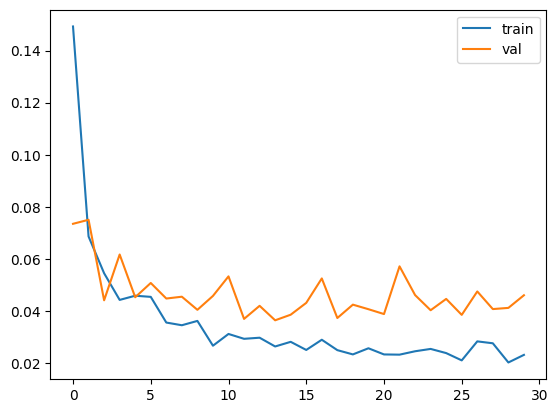

In [8]:
plot_losses(train_loss_lst,val_loss_lst)

In [9]:
from pathlib import Path
# save the model
path1=Path("model.pth")
torch.save(net,path1)

path2=Path("model_state_dict.pth")
# Save the state dictionary
torch.save(net.state_dict(), path2)


# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/ 


In [10]:
#net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [11]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [12]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')


Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [13]:
def test(loader, name, net, wrong_counts, verbose=True):
    correct = 0
    total = 0
    
    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name, disable=not verbose):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1
                    
                total += 1

    accuracy = round(correct / total, 3)
    if verbose: print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        if verbose: print(f'Wrong counts for the digit {key}: {value}')
        
    return accuracy

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:00<00:00, 41.58it/s]

Accuracy: 0.994
Wrong counts for the digit 0: 4
Wrong counts for the digit 1: 4
Wrong counts for the digit 2: 15
Wrong counts for the digit 3: 4
Wrong counts for the digit 4: 4


0.994

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [14]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9
#######
#TO-DO#
train_mask_subset2 = torch.tensor([label in [5, 6, 7, 8, 9] for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in [5, 6, 7, 8, 9] for label in mnist_test.targets])
#######

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)


# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [17]:
#######
#TO-DO#
test(test_loader_subset2, "Testing subset2", net, {i: 5 for i in range(5, 10)})
#######

Testing subset2: 100%|██████████| 38/38 [00:00<00:00, 38.87it/s]

Accuracy: 0.4
Wrong counts for the digit 5: 765
Wrong counts for the digit 6: 927
Wrong counts for the digit 7: 753
Wrong counts for the digit 8: 406
Wrong counts for the digit 9: 90


0.4

# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [18]:
#######
#TO-DO#

train_loss_lst, val_loss_lst = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)
#######

Training: 100%|██████████| 161/161 [00:03<00:00, 46.63it/s, loss=6.44]


Epoch [1/10] Train Loss: 6.435617251425796


Validation: 100%|██████████| 69/69 [00:01<00:00, 51.46it/s, loss=4.76]


Epoch [1/10] Validation Loss: 4.755531894987908


Training: 100%|██████████| 161/161 [00:03<00:00, 46.36it/s, loss=4.16]


Epoch [2/10] Train Loss: 4.164308528722443


Validation: 100%|██████████| 69/69 [00:01<00:00, 55.82it/s, loss=2.82]


Epoch [2/10] Validation Loss: 2.823601080023724


Training: 100%|██████████| 161/161 [00:03<00:00, 50.95it/s, loss=2.53]


Epoch [3/10] Train Loss: 2.532960149812402


Validation: 100%|██████████| 69/69 [00:01<00:00, 51.88it/s, loss=1.58]


Epoch [3/10] Validation Loss: 1.5841916574948076


Training: 100%|██████████| 161/161 [00:03<00:00, 49.06it/s, loss=1.52]


Epoch [4/10] Train Loss: 1.5205668581198462


Validation: 100%|██████████| 69/69 [00:01<00:00, 49.30it/s, loss=0.892]


Epoch [4/10] Validation Loss: 0.8918589880501014


Training: 100%|██████████| 161/161 [00:03<00:00, 47.13it/s, loss=0.986]


Epoch [5/10] Train Loss: 0.986046812919356


Validation: 100%|██████████| 69/69 [00:01<00:00, 48.14it/s, loss=0.603]


Epoch [5/10] Validation Loss: 0.6026910068332285


Training: 100%|██████████| 161/161 [00:03<00:00, 46.47it/s, loss=0.729]


Epoch [6/10] Train Loss: 0.729363660449567


Validation: 100%|██████████| 69/69 [00:01<00:00, 54.44it/s, loss=0.469]


Epoch [6/10] Validation Loss: 0.4691127892853557


Training: 100%|██████████| 161/161 [00:03<00:00, 48.42it/s, loss=0.598]


Epoch [7/10] Train Loss: 0.5983326886751636


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.82it/s, loss=0.388]


Epoch [7/10] Validation Loss: 0.3882186607174251


Training: 100%|██████████| 161/161 [00:03<00:00, 48.36it/s, loss=0.505]


Epoch [8/10] Train Loss: 0.5048883755384765


Validation: 100%|██████████| 69/69 [00:01<00:00, 52.84it/s, loss=0.33] 


Epoch [8/10] Validation Loss: 0.3304914426112521


Training: 100%|██████████| 161/161 [00:03<00:00, 50.97it/s, loss=0.448]


Epoch [9/10] Train Loss: 0.4478882155988527


Validation: 100%|██████████| 69/69 [00:01<00:00, 54.84it/s, loss=0.288]


Epoch [9/10] Validation Loss: 0.288224747431451


Training: 100%|██████████| 161/161 [00:03<00:00, 49.50it/s, loss=0.397]


Epoch [10/10] Train Loss: 0.3968513878235906


Validation: 100%|██████████| 69/69 [00:01<00:00, 52.29it/s, loss=0.256]

Epoch [10/10] Validation Loss: 0.25574878376463184


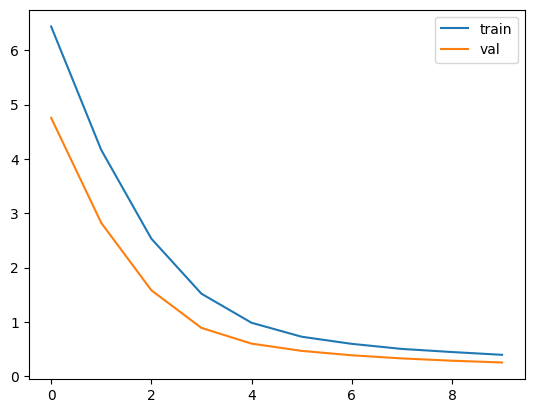

In [19]:
#plot the train and validation losses
#######
#TO-DO#
plot_losses(train_loss_lst,val_loss_lst)
#######

In [20]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

#######
#TO-DO#
test_subset2_acc = test(test_loader_subset2, "Testing subset2", net, {i: 5 for i in range(5, 10)})
#######

Testing subset2: 100%|██████████| 38/38 [00:00<00:00, 40.96it/s]

Accuracy: 0.927
Wrong counts for the digit 5: 83
Wrong counts for the digit 6: 42
Wrong counts for the digit 7: 90
Wrong counts for the digit 8: 90
Wrong counts for the digit 9: 77


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [21]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()
        
        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)
        
        # Define lora hyperparameters
        #######
        #TO-DO#
        self.lora_rank = lora_rank
        self.l1_lora = self.pretrained_net.linear1.weight.shape
        self.l2_lora = self.pretrained_net.linear2.weight.shape
        self.l3_lora = self.pretrained_net.linear3.weight.shape
        #######
        
        # Define lora weights matrices for each layer in pretrained model
        #######
        #TO-DO#
        self.l1_lora_A = torch.nn.Linear(self.l1_lora[1], self.lora_rank, bias=False)
        self.l2_lora_A = torch.nn.Linear(self.l2_lora[1], self.lora_rank, bias=False)
        self.l3_lora_A = torch.nn.Linear(self.l3_lora[1], self.lora_rank, bias=False)
        self.l1_lora_B = torch.nn.Linear(self.lora_rank, self.l1_lora[0], bias=False)
        self.l2_lora_B = torch.nn.Linear(self.lora_rank, self.l2_lora[0], bias=False)
        self.l3_lora_B = torch.nn.Linear(self.lora_rank, self.l3_lora[0], bias=False)
        #######
        
        # Initialization for lora layers 
        #######
        #TO-DO#
        torch.nn.init.normal_(self.l1_lora_A.weight)
        torch.nn.init.normal_(self.l2_lora_A.weight)
        torch.nn.init.normal_(self.l3_lora_A.weight)
        
        torch.nn.init.zeros_(self.l1_lora_B.weight)
        torch.nn.init.zeros_(self.l2_lora_B.weight)
        torch.nn.init.zeros_(self.l3_lora_B.weight)
        #######
                    
        # freeze non lora weights
        #######
        #TO-DO#
        for param in self.pretrained_net.parameters():
            param.requires_grad = False
        #######
                
    def lora_linear(self, x, layer, lora_A, lora_B):
        #Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        return layer(x) + lora_B(lora_A(x))
                     
        
    def forward(self, input):
        x = input.view(-1, 28*28)
        
        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #complete the remaining code (layer 2 and 3)
        #######
        #TO-DO#
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B)
        #######
        
        return x

lora_rank=1
# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank).to(device)


Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [22]:
# Count the parameters introduced by lora layers
#######
#TO-DO#
print(f'Total number of parameters: {sum(p.numel() for p in modified_net.parameters()):,}')
print(f'Total number of parameters in original model: {total_parameters_original:,}')
print(f'Number of parameters introduced by LORA: {sum(p.numel() for p in modified_net.parameters() if p.requires_grad):,}')
#######

Total number of parameters: 2,803,794
Total number of parameters in original model: 2,797,005
Number of parameters introduced by LORA: 6,789


# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [23]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
#######
#TO-DO#
train_loss_lst, val_loss_lst = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=30)
#######

Training: 100%|██████████| 161/161 [00:03<00:00, 48.78it/s, loss=7.65]


Epoch [1/30] Train Loss: 7.647141184125628


Validation: 100%|██████████| 69/69 [00:01<00:00, 53.73it/s, loss=7.13]


Epoch [1/30] Validation Loss: 7.129728524581246


Training: 100%|██████████| 161/161 [00:03<00:00, 46.72it/s, loss=7.49]


Epoch [2/30] Train Loss: 7.487621716090611


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.52it/s, loss=6.93]


Epoch [2/30] Validation Loss: 6.934654249661211


Training: 100%|██████████| 161/161 [00:03<00:00, 50.22it/s, loss=7.28]


Epoch [3/30] Train Loss: 7.283531123806971


Validation: 100%|██████████| 69/69 [00:01<00:00, 55.07it/s, loss=6.72]


Epoch [3/30] Validation Loss: 6.716169682101927


Training: 100%|██████████| 161/161 [00:03<00:00, 49.56it/s, loss=7.07]


Epoch [4/30] Train Loss: 7.067639768493842


Validation: 100%|██████████| 69/69 [00:01<00:00, 48.98it/s, loss=6.47]


Epoch [4/30] Validation Loss: 6.466315062149711


Training: 100%|██████████| 161/161 [00:03<00:00, 45.71it/s, loss=6.83]


Epoch [5/30] Train Loss: 6.827491644746768


Validation: 100%|██████████| 69/69 [00:01<00:00, 56.92it/s, loss=6.18]


Epoch [5/30] Validation Loss: 6.184674152429553


Training: 100%|██████████| 161/161 [00:03<00:00, 47.09it/s, loss=6.5] 


Epoch [6/30] Train Loss: 6.495599574924256


Validation: 100%|██████████| 69/69 [00:01<00:00, 49.29it/s, loss=5.87]


Epoch [6/30] Validation Loss: 5.871859211852585


Training: 100%|██████████| 161/161 [00:03<00:00, 48.53it/s, loss=6.22]


Epoch [7/30] Train Loss: 6.218846809790001


Validation: 100%|██████████| 69/69 [00:01<00:00, 55.45it/s, loss=5.54]


Epoch [7/30] Validation Loss: 5.535978728446407


Training: 100%|██████████| 161/161 [00:03<00:00, 48.09it/s, loss=5.86]


Epoch [8/30] Train Loss: 5.85572105757198


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.99it/s, loss=5.19]


Epoch [8/30] Validation Loss: 5.192913476971612


Training: 100%|██████████| 161/161 [00:03<00:00, 45.09it/s, loss=5.59]


Epoch [9/30] Train Loss: 5.5876700270990405


Validation: 100%|██████████| 69/69 [00:01<00:00, 53.85it/s, loss=4.87]


Epoch [9/30] Validation Loss: 4.871168554693028


Training: 100%|██████████| 161/161 [00:03<00:00, 47.69it/s, loss=5.27]


Epoch [10/30] Train Loss: 5.270925290836311


Validation: 100%|██████████| 69/69 [00:01<00:00, 54.11it/s, loss=4.57]


Epoch [10/30] Validation Loss: 4.568634717360787


Training: 100%|██████████| 161/161 [00:03<00:00, 46.08it/s, loss=5.07]


Epoch [11/30] Train Loss: 5.067435103173581


Validation: 100%|██████████| 69/69 [00:01<00:00, 51.04it/s, loss=4.29]


Epoch [11/30] Validation Loss: 4.291403936303181


Training: 100%|██████████| 161/161 [00:03<00:00, 47.09it/s, loss=4.77]


Epoch [12/30] Train Loss: 4.766581989963602


Validation: 100%|██████████| 69/69 [00:01<00:00, 49.45it/s, loss=4.04]


Epoch [12/30] Validation Loss: 4.035335706627888


Training: 100%|██████████| 161/161 [00:03<00:00, 45.90it/s, loss=4.52]


Epoch [13/30] Train Loss: 4.517511388529902


Validation: 100%|██████████| 69/69 [00:01<00:00, 47.51it/s, loss=3.79]


Epoch [13/30] Validation Loss: 3.7949193836986153


Training: 100%|██████████| 161/161 [00:03<00:00, 46.79it/s, loss=4.34]


Epoch [14/30] Train Loss: 4.342255587903609


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.55it/s, loss=3.56]


Epoch [14/30] Validation Loss: 3.5603693291760874


Training: 100%|██████████| 161/161 [00:03<00:00, 46.40it/s, loss=4.08]


Epoch [15/30] Train Loss: 4.079303919158367


Validation: 100%|██████████| 69/69 [00:01<00:00, 51.98it/s, loss=3.33]


Epoch [15/30] Validation Loss: 3.3337254835211714


Training: 100%|██████████| 161/161 [00:03<00:00, 47.31it/s, loss=3.87]


Epoch [16/30] Train Loss: 3.8696075418721074


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.98it/s, loss=3.11]


Epoch [16/30] Validation Loss: 3.1145902543828106


Training: 100%|██████████| 161/161 [00:03<00:00, 45.15it/s, loss=3.66]


Epoch [17/30] Train Loss: 3.658817052100756


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.44it/s, loss=2.9] 


Epoch [17/30] Validation Loss: 2.902143651160641


Training: 100%|██████████| 161/161 [00:03<00:00, 45.52it/s, loss=3.47]


Epoch [18/30] Train Loss: 3.466820472515888


Validation: 100%|██████████| 69/69 [00:01<00:00, 48.62it/s, loss=2.7] 


Epoch [18/30] Validation Loss: 2.7017956332883974


Training: 100%|██████████| 161/161 [00:03<00:00, 47.21it/s, loss=3.22]


Epoch [19/30] Train Loss: 3.2216926065290936


Validation: 100%|██████████| 69/69 [00:01<00:00, 47.31it/s, loss=2.52]


Epoch [19/30] Validation Loss: 2.520296739495319


Training: 100%|██████████| 161/161 [00:03<00:00, 46.80it/s, loss=3.09]


Epoch [20/30] Train Loss: 3.088236451889417


Validation: 100%|██████████| 69/69 [00:01<00:00, 53.94it/s, loss=2.36]


Epoch [20/30] Validation Loss: 2.3612263202667236


Training: 100%|██████████| 161/161 [00:03<00:00, 47.32it/s, loss=2.9] 


Epoch [21/30] Train Loss: 2.899587815592748


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.80it/s, loss=2.22]


Epoch [21/30] Validation Loss: 2.2202302131099976


Training: 100%|██████████| 161/161 [00:03<00:00, 43.40it/s, loss=2.72]


Epoch [22/30] Train Loss: 2.721776372897699


Validation: 100%|██████████| 69/69 [00:01<00:00, 48.49it/s, loss=2.1] 


Epoch [22/30] Validation Loss: 2.0992085052573164


Training: 100%|██████████| 161/161 [00:03<00:00, 47.70it/s, loss=2.6] 


Epoch [23/30] Train Loss: 2.6019782886742067


Validation: 100%|██████████| 69/69 [00:01<00:00, 53.17it/s, loss=1.99]


Epoch [23/30] Validation Loss: 1.9945893754129824


Training: 100%|██████████| 161/161 [00:03<00:00, 48.10it/s, loss=2.51]


Epoch [24/30] Train Loss: 2.5109601457666906


Validation: 100%|██████████| 69/69 [00:01<00:00, 54.63it/s, loss=1.9] 


Epoch [24/30] Validation Loss: 1.8995533058608787


Training: 100%|██████████| 161/161 [00:03<00:00, 47.11it/s, loss=2.43]


Epoch [25/30] Train Loss: 2.4284076742503955


Validation: 100%|██████████| 69/69 [00:01<00:00, 47.07it/s, loss=1.81]


Epoch [25/30] Validation Loss: 1.8140737630318904


Training: 100%|██████████| 161/161 [00:03<00:00, 45.46it/s, loss=2.3] 


Epoch [26/30] Train Loss: 2.2979321798182424


Validation: 100%|██████████| 69/69 [00:01<00:00, 52.50it/s, loss=1.74]


Epoch [26/30] Validation Loss: 1.7360018094380696


Training: 100%|██████████| 161/161 [00:03<00:00, 46.36it/s, loss=2.22]


Epoch [27/30] Train Loss: 2.2201744044049185


Validation: 100%|██████████| 69/69 [00:01<00:00, 54.03it/s, loss=1.67]


Epoch [27/30] Validation Loss: 1.6650308266929958


Training: 100%|██████████| 161/161 [00:03<00:00, 46.71it/s, loss=2.17]


Epoch [28/30] Train Loss: 2.17024168390665


Validation: 100%|██████████| 69/69 [00:01<00:00, 50.96it/s, loss=1.6] 


Epoch [28/30] Validation Loss: 1.5996942969336025


Training: 100%|██████████| 161/161 [00:03<00:00, 46.98it/s, loss=2.1] 


Epoch [29/30] Train Loss: 2.1023079882497373


Validation: 100%|██████████| 69/69 [00:01<00:00, 49.53it/s, loss=1.54]


Epoch [29/30] Validation Loss: 1.5399595723635908


Training: 100%|██████████| 161/161 [00:03<00:00, 47.97it/s, loss=2.04]


Epoch [30/30] Train Loss: 2.035951392991202


Validation: 100%|██████████| 69/69 [00:01<00:00, 51.99it/s, loss=1.48]

Epoch [30/30] Validation Loss: 1.4826517752979114


In [24]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"
#######
#TO-DO#

assert all(torch.equal(original_weights[name[len(name.split('.')[0]) + 1:]], param) for name, param in modified_net.named_parameters() if param.requires_grad == False)
#######

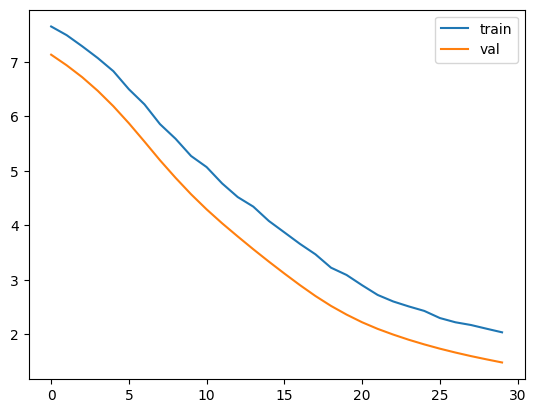

In [25]:
#plot losses
#######
#TO-DO#
plot_losses(train_loss_lst, val_loss_lst)
#######

In [28]:
#Compute test accuracy on MNIST 5...9 for that lora rank
#######
#TO-DO#
test_subset2_acc_lora = test(test_loader_subset2, "Testing subset2", modified_net, {i: 5 for i in range(5, 10)})

#######

Testing subset2: 100%|██████████| 38/38 [00:00<00:00, 40.68it/s]

Accuracy: 0.657
Wrong counts for the digit 5: 343
Wrong counts for the digit 6: 257
Wrong counts for the digit 7: 526
Wrong counts for the digit 8: 426
Wrong counts for the digit 9: 142


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added 

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9 

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

In [29]:
def train_and_evaluate_LoRA(lora_rank, train_loader_subset2, val_loader_subset2, test_loader_subset2, device, epochs=5):
    modified_net = ModifiedClassifier(lora_rank).to(device)
    nb_lora_parameters = sum(p.numel() for p in modified_net.parameters() if p.requires_grad)
    
    _, _ = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=epochs, verbose=False)
    test_subset2_acc_lora = test(test_loader_subset2, "Testing subset2", modified_net, {i: 5 for i in range(5, 10)}, verbose=False)
    return nb_lora_parameters, test_subset2_acc_lora
    

In [30]:
lora_rank_lst = [1, 2, 4, 8, 16, 32, 64]
#lora_rank_lst = [1, 2]
epochs = 30
nb_runs = 5


# running independant experiments in parallel
from joblib import Parallel, delayed
from itertools import repeat, chain
experiments_results = Parallel(n_jobs=-1, verbose=False)(delayed(train_and_evaluate_LoRA)(lora_rank, train_loader_subset2, val_loader_subset2, test_loader_subset2, device, epochs=epochs) for lora_rank in chain.from_iterable(repeat(i, nb_runs) for i in lora_rank_lst))

# running independant experiments sequentially
#experiments_results = [train_and_evaluate_LoRA(lora_rank, train_loader_subset2, val_loader_subset2, test_loader_subset2, device, epochs=epochs) for lora_rank in chain.from_iterable(repeat(i, nb_runs) for i in lora_rank_lst)]


In [31]:
mean_results = [(np.mean([result[0] for result in experiments_results[i:i+nb_runs]]),
                np.mean([result[1] for result in experiments_results[i:i+nb_runs]])) for i in range(0, len(experiments_results), nb_runs)]

std_results = [np.std([result[1] for result in experiments_results[i:i+nb_runs]]) for i in range(0, len(experiments_results), nb_runs)]

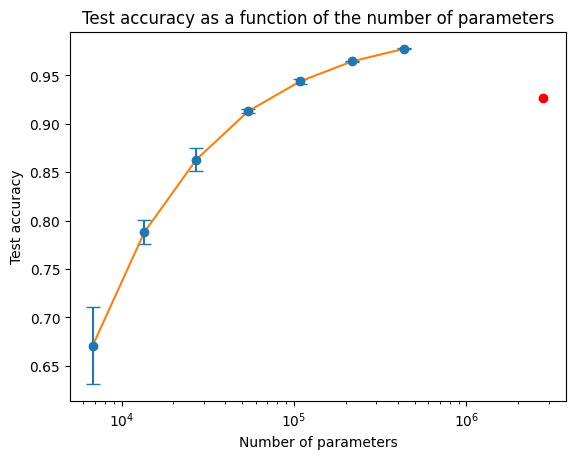

In [32]:
plt.errorbar([int(x[0]) for x in mean_results], [x[1] for x in mean_results], yerr=std_results, fmt='o', capsize=5)
plt.plot([int(x[0]) for x in mean_results], [x[1] for x in mean_results])
plt.scatter([sum([param.numel() for param in net.parameters()])], [test_subset2_acc], color='red', label='Original model')
plt.xscale('log')
plt.xlabel('Number of parameters')
plt.ylabel('Test accuracy')
plt.title('Test accuracy as a function of the number of parameters')
plt.show()

In [34]:
# Compute fraction of parameters of LoRA compared to the original model
434496/2797005

0.15534330471343455

In the plot from above, we see that LoRA matches, and even outperform the fine-tuned base model, whilst only optimizing for a fraction of the parameters ($15\%$ for the LoRA with rank 64). This was to be expected, as in the end, the LoRA model has more additional capacity (because it has more parameters) while still keeping the knowledge from the base learner.

This is very promising, as it makes the finetuning costs of big models very affordable. The LoRA technique is best when applied to foundation models, making it very natural in natural language processing and computer vision. For example, a base LLM can be, thanks to LoRA, finetuned for a diverse array of applications (translation, custumer support, domain specific language like law or medecine...). Furthermore, as the base knowledge is not removed, one could easily switch between already trained LoRA adapters to adapt for different tasks.

However, this increased capacity comes with a cost: the final model, because it is larger, runs slower than the base model (see plot from below). In application where latency is important - and natural language applications are no exception - this can be very detrimental, and is definitively a thing to keep in mind.

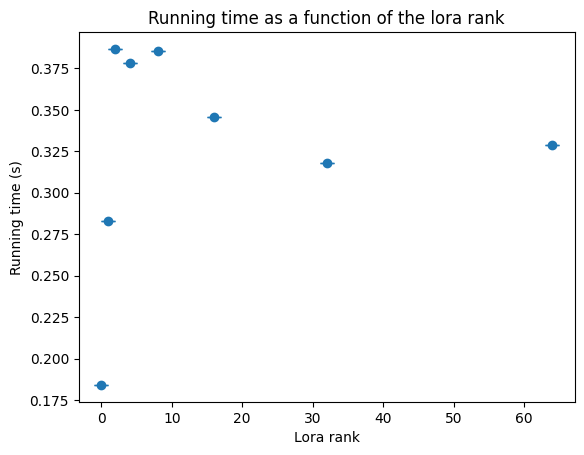

In [35]:
# measure running time difference between lora rank 32 and no lora
from time import perf_counter

def inference_running_time(net):
    times = []
    net.eval()
    with torch.no_grad():
        for i in range(10):
            _ = torch.manual_seed(i)
            x_train = torch.rand(128, 784).to(device)
            start = perf_counter()
            for _ in range(1_000):
                net(x_train)
            end = perf_counter()
        times.append(end - start)
    return np.mean(times), np.std(times)

running_times = [inference_running_time(ModifiedClassifier(lora_rank).to(device)) for lora_rank in lora_rank_lst]
running_times_no_lora = inference_running_time(net)
running_times.append(running_times_no_lora)

plt.errorbar(lora_rank_lst + [0], [x[0] for x in running_times], yerr=[x[1] for x in running_times], fmt='o', capsize=5)
#plt.xscale('log')
plt.xlabel('Lora rank')
plt.ylabel('Running time (s)')
plt.title('Running time as a function of the lora rank')
plt.show()


In [36]:
running_times

[(0.2828755829978036, 0.0),
 (0.386686429992551, 0.0),
 (0.3782001939980546, 0.0),
 (0.3855644290015334, 0.0),
 (0.3459164609957952, 0.0),
 (0.3179649710073136, 0.0),
 (0.3289135419909144, 0.0),
 (0.1841965200001141, 0.0)]